In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [76]:
block_size = 3
X, Y = [], []
for w in words:
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix]
    
X = torch.tensor(X)
Y = torch.tensor(Y)

In [77]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [134]:
# build dataset 

def build_dataset(words):
    block_size = 3 # context length: how many characters do we take to predict the next one 
    X, Y = [], []

    for w in words:

        context = [0] * block_size
        
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y



import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])





torch.Size([182322, 3]) torch.Size([182322])
torch.Size([22875, 3]) torch.Size([22875])
torch.Size([22949, 3]) torch.Size([22949])


In [135]:
Xtr.shape, Ytr.shape

(torch.Size([182322, 3]), torch.Size([182322]))

In [172]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g, requires_grad=True)
W1 = torch.randn((30, 300), generator=g, requires_grad=True)
b1 = torch.randn(300, generator=g, requires_grad=True)
W2 = torch.randn((300, 27), generator=g, requires_grad=True)
b2 = torch.randn(27, generator=g, requires_grad=True)
parameters = [C, W1, b1, W2, b2]

In [173]:
sum(p.nelement() for p in parameters) # number of parameters in total

17697

In [174]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10 ** lre

In [217]:
# lri = []
lossi = []
stepi = []

for i in range(100000):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))

    # forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix])
    # print(loss.item())

    for p in parameters:
        p.grad = None

    # backward pass 
    loss.backward()

    # update
    # lr = lrs[i]
    lr = 0.0007
    for p in parameters:
        p.data += -lr * p.grad
    
    # lri.append(lre[i])
    # lossi.append(loss.item())
    stepi.append(i)
    lossi.append(loss.log10().item())

print(loss.item())




2.146487236022949


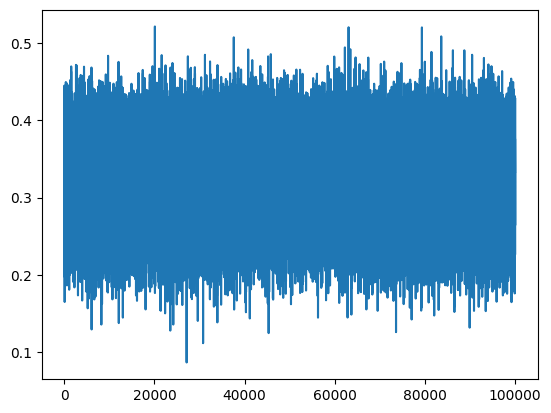

In [218]:
plt.plot(stepi, lossi)

In [219]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1106, grad_fn=<NllLossBackward0>)

In [223]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1765, grad_fn=<NllLossBackward0>)

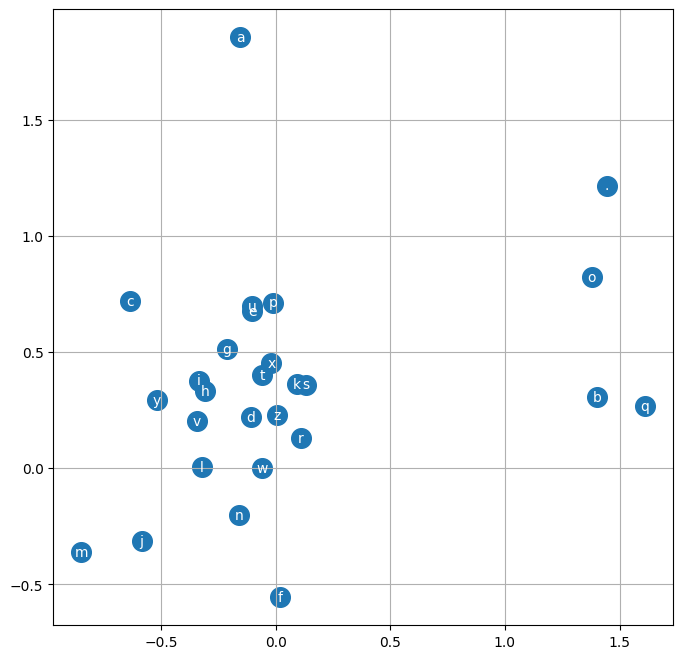

In [221]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha="center", va="center", color="white")
plt.grid('minor')

In [222]:
# sample from the model 
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)

        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out))

mona.
mayah.
seel.
ndyn.
alee.
than.
endrari.
aderedielin.
shy.
jen.
eden.
esmanareelyzion.
kalin.
shabergiairiel.
kin.
renelionnie.
casuya.
ged.
ryyah.
faehsyn.
